See https://hbctraining.github.io/Intro-to-ChIPseq/lessons/12_functional_analysis.html

In [1]:
BiocManager::install("ChIPseeker")
BiocManager::install("GO.db")
BiocManager::install("DO.db")
BiocManager::install("EnsDb.Hsapiens.v75")
BiocManager::install("clusterProfiler")
BiocManager::install("org.Hs.eg.db")
BiocManager::install("TxDb.Hsapiens.UCSC.hg38.knownGene")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'ChIPseeker'”
Old packages: 'ape', 'aplot', 'biomaRt', 'class', 'ensembldb', 'fansi',
  'foreign', 'igraph', 'MASS', 'nlme', 'nnet', 'pkgdown', 'Rcpp', 'rjson',
  'shadowtext', 'spatial', 'terra', 'tidytree'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'GO.db'”
Old packages: 'ape', 'aplot', 'biomaRt', 'class', 'ensembldb', 'fansi',
  'foreign', 'ig

In [2]:
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(EnsDb.Hsapiens.v75)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)



ChIPseeker v1.30.3  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S

In [26]:
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
peakfile <- "../data/raw/eclip/RPL22-ZR751_clearCLIP.pool.tag.uniq.del.CIMS.fdr10.f10.bed"
peakAnno <- annotatePeak(peakfile, tssRegion=c(-1000, 1000), TxDb=txdb)

>> loading peak file...				 2022-01-14 20:20:10 
>> preparing features information...		 2022-01-14 20:20:11 
>> identifying nearest features...		 2022-01-14 20:20:11 
>> calculating distance from peak to TSS...	 2022-01-14 20:20:13 
>> assigning genomic annotation...		 2022-01-14 20:20:13 
>> assigning chromosome lengths			 2022-01-14 20:20:19 
>> done...					 2022-01-14 20:20:19 


pdf 
  2

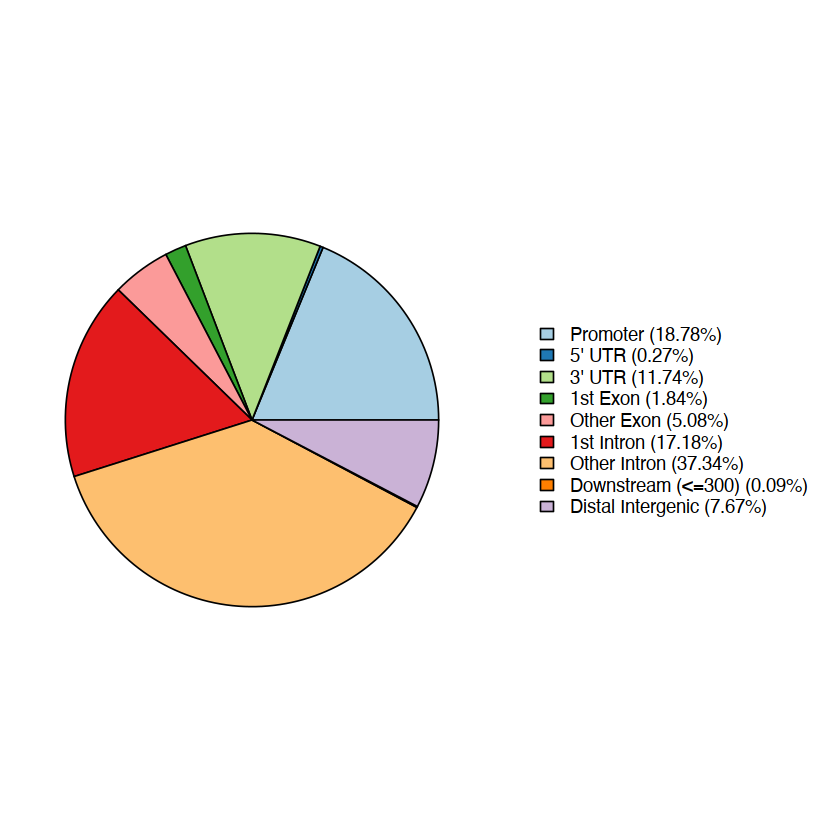

In [28]:
pdf("../plots/peak_regions.pdf", width=6, height=3)
plotAnnoPie(peakAnno)
dev.off()
plotAnnoPie(peakAnno)

In [29]:
peakAnnoDf <- data.frame(peakAnno@anno)
peakEntrez <- peakAnnoDf$geneId
annotations_edb <- AnnotationDbi::select(EnsDb.Hsapiens.v75,
                                         keys = peakEntrez,
                                         columns = c("GENENAME","ENTREZID","GENEID"),
                                         keytype = "ENTREZID")
annotations_edb$ENTREZID <- as.character(annotations_edb$ENTREZID)

write.csv(peakAnnoDf,"../data/raw/peak_anno.csv", row.names = TRUE)
write.csv(annotations_edb,"../data/raw/peak_gene_ids.csv", row.names = TRUE)

In [30]:
ego <- enrichGO(gene = peakEntrez, 
                    keyType = "ENTREZID", 
                    OrgDb = org.Hs.eg.db, 
                    ont = "BP", 
                    pAdjustMethod = "BH", 
                    qvalueCutoff = 0.05, 
                    readable = TRUE)

pdf("../plots/go_clip_enrichment.pdf", width=6, height=4)
dotplot(ego, showCategory=10)+theme_light()
dev.off()

pdf 
  2

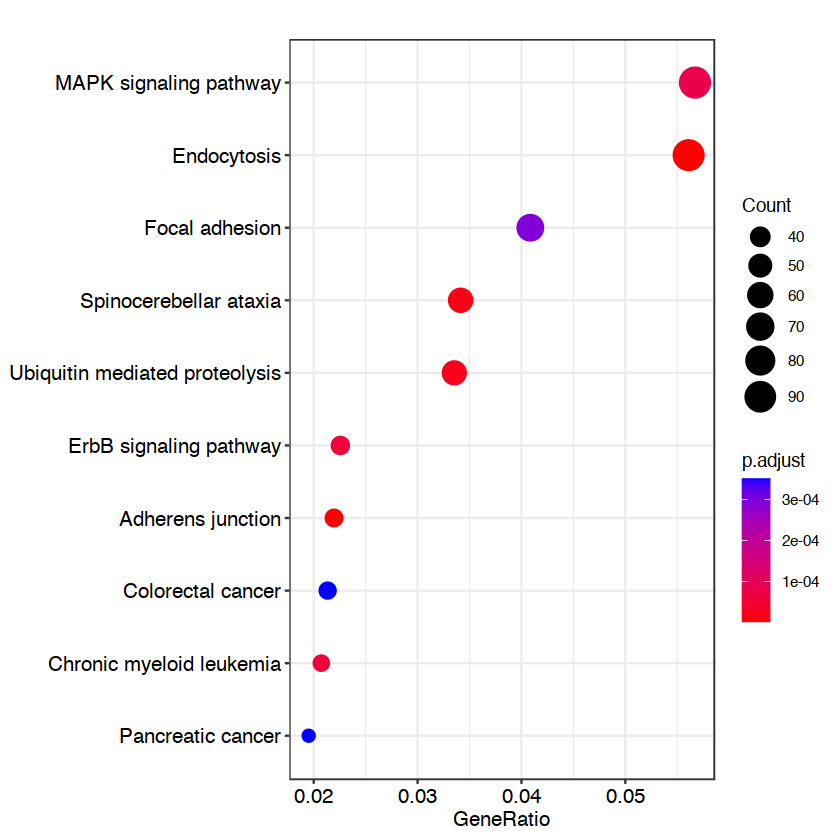

In [32]:
ekegg <- enrichKEGG(gene = peakEntrez,
                 organism = 'hsa',
                 pvalueCutoff = 0.05)

dotplot(ekegg)

In [33]:
gene_matrix <- getTagMatrix(peak = peakAnno@anno, 
                           TxDb = txdb,
                           upstream = 1000,
                           downstream = 1000, 
                           by = "gene",
                           type = "end_site",
                           nbin=250
                           )

pdf("../plots/tts_enrichment.pdf", width=5, height=3) 
plotPeakProf(gene_matrix, xlab="Gene end (5'->3')", ylab = "Peak Frequency", conf = 0.95, resample = 1000) + theme_minimal()
dev.off()

>> binning method is used...2022-01-14 20:22:51
>> preparing end_site regions by gene... 2022-01-14 20:22:51
>> preparing tag matrix by binning...  2022-01-14 20:22:51 
>> Running bootstrapping for tag matrix...		 2022-01-14 20:22:56 


pdf 
  2